<a href="https://colab.research.google.com/github/AchrafAsh/best-istanbul-datathon/blob/main/arima_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime

plt.rcParams.update({'figure.figsize': (8, 5), 'figure.dpi': 120})

In [14]:
%%capture
!pip install statsmodels

In [23]:
import statsmodels.api as sm

In [3]:
# dataset paths
path_provider_1 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider1_Usecase2.csv"
path_provider_2 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider2_Usecase2.csv"
path_provider_3 = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/Provider3_Usecase2.csv"
path_generation = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/ActualGeneration_Usecase2_v2.csv"

In [6]:
# format date
def format_date(date:int):
    date_string = str(date)
    year = date_string[:4]
    month = date_string[4:6]
    day = date_string[6:]
    # convert to datetime
    return f"{year}-{month}-{day}"

In [7]:
def get_provider_data(path: str):
    df_provider = pd.read_csv(path, sep=";")
    # change column names
    df_provider.rename(columns={ "Datekey": "date",
                                "ProviderId": "provider_id",
                                "Hour": "hour",
                                "WindSpeed": "wind_speed",
                                "WindDirection": "wind_direction",
                                "Temperature": "temperature",
                                "Pressure": "pressure",
                                "Humidity": "humidity",
                                "PowerWOAvailability": "power"},
                        inplace=True)
    # format date
    df_provider["date"] = df_provider["date"].apply(format_date)
    # aggregate date and hour
    df_provider["date"] = df_provider["date"] + "T" + df_provider["hour"]
    # convert to datetime object
    df_provider["date"] = df_provider.date.apply(
        lambda d: datetime.strptime(d,"%Y-%m-%dT%H:%M")
        )
    # drop hour column
    df_provider.drop(columns=["hour"], inplace=True)
    return df_provider

In [18]:
def average_forecasts(*providers):
    provider_1 = providers[0]
    provider_2 = providers[1]
    provider_3 = providers[2]
    
    provider_final_df = pd.DataFrame(index = list(provider_1.index), columns = list(provider_1.columns))
    provider_final_df.date = provider_1.date
    
    del provider_final_df['provider_id']
    
    for column in list(provider_final_df.columns):
        
        if column != 'date':
            to_average = pd.DataFrame() 
            to_average[column+'_1'] = provider_1[column]
            to_average[column+'_2'] = provider_2[column]
            to_average[column+'_3'] = provider_3[column]

            provider_final_df[column] = to_average.mean(axis = 1)
    
    return(provider_final_df)

In [10]:
provider_1 = get_provider_data(path_provider_1)
provider_2 = get_provider_data(path_provider_2)
provider_3 = get_provider_data(path_provider_3)

In [19]:
avg_forecasts = average_forecasts(provider_1, provider_2, provider_3)

In [139]:
def get_actual_generation():
    filepath = "https://raw.githubusercontent.com/AchrafAsh/best-istanbul-datathon/main/ActualGeneration_Usecase2_v2.csv"
    actual_generation = pd.read_csv(filepath, sep=";", parse_dates=["PCTimeStamp"])
    actual_generation.rename(columns={"PCTimeStamp": "date",
                                  "PowerMWh": "power"},
                            inplace=True)
    
    
    actual_generation.replace(float("inf"), np.nan, inplace=True)
    actual_generation.fillna(method="ffill", inplace=True)
    
    return actual_generation

In [140]:
actual_generation = get_actual_generation()


### Arima

### Determining orders

In [141]:
y_train = actual_generation.power[:12000]
y_test = actual_generation.power[12000:]

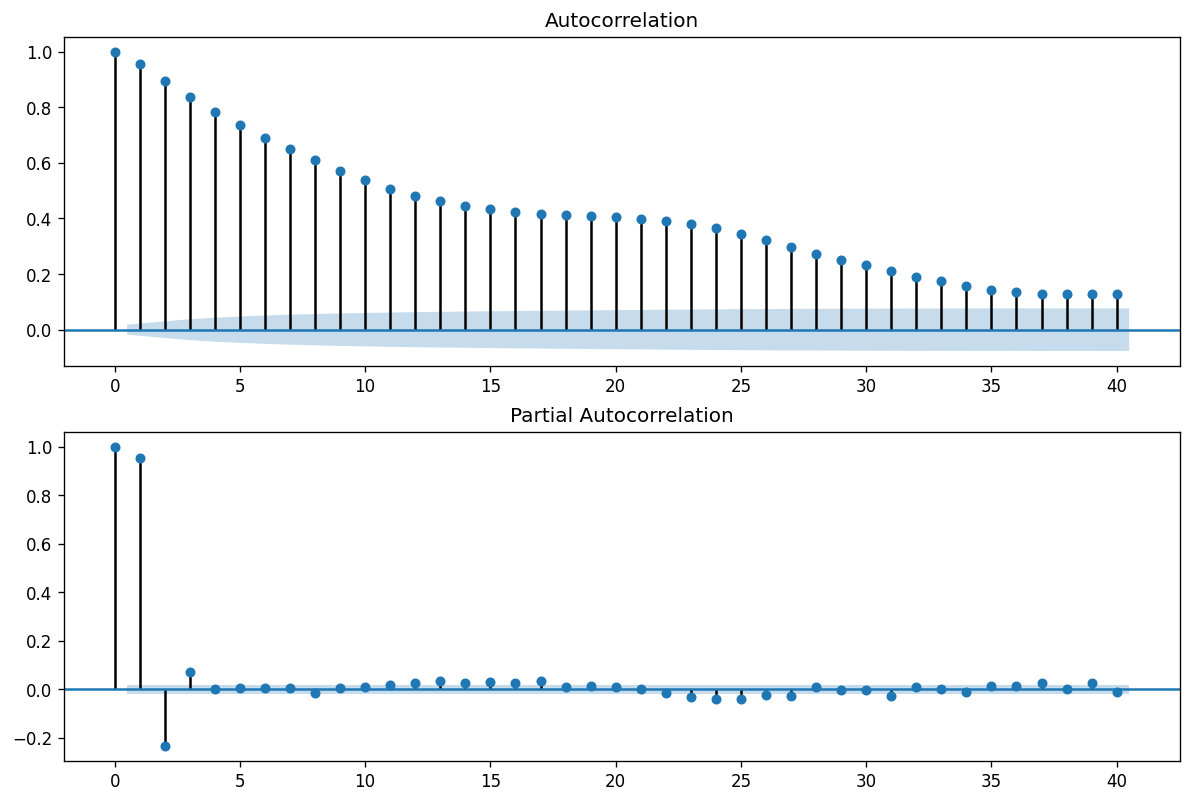

In [142]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(y_train, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(y_train, lags=40, ax=ax2)

In [143]:
arima = sm.tsa.ARIMA(y_train, order=(4, 0, 0))

In [144]:
res = arima.fit()

In [76]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  power   No. Observations:                12504
Model:                     ARMA(4, 0)   Log Likelihood              -39515.821
Method:                       css-mle   S.D. of innovations              5.704
Date:                Sat, 05 Jun 2021   AIC                          79043.643
Time:                        14:50:54   BIC                          79088.245
Sample:                             0   HQIC                         79058.574
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          22.0748      0.986     22.385      0.000      20.142      24.008
ar.L1.power     1.2004      0.009    134.239      0.000       1.183       1.218
ar.L2.power    -0.3241      0.014    -23.219      0.000      -0.351      -0.297
ar.L3.power     0.0654      0.014      4.685      0.000       0.038       0.093
ar.L4.power     0.0067      0.009      0.748      0.455      -0.011       0.024
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0671           -0.0000j            1.0671           -0.0000
AR.2            1.6532           -2.6774j            3.1466           -0.1620
AR.3            1.6532           +2.6774j            3.1466            0.1620
AR.4          -14.1558           -0.0000j           14.1558           -0.5000
-----------------------------------------------------------------------------
"""

In [77]:
res.params

const          22.074814
ar.L1.power     1.200371
ar.L2.power    -0.324128
ar.L3.power     0.065403
ar.L4.power     0.006686
dtype: float64

In [150]:
y_train.index

RangeIndex(start=0, stop=12000, step=1)

In [153]:
preds = arima.predict(res.params, start=0, end=11999)

In [158]:
np.sqrt(np.mean((preds - y_test)**2))

5.668199342063092

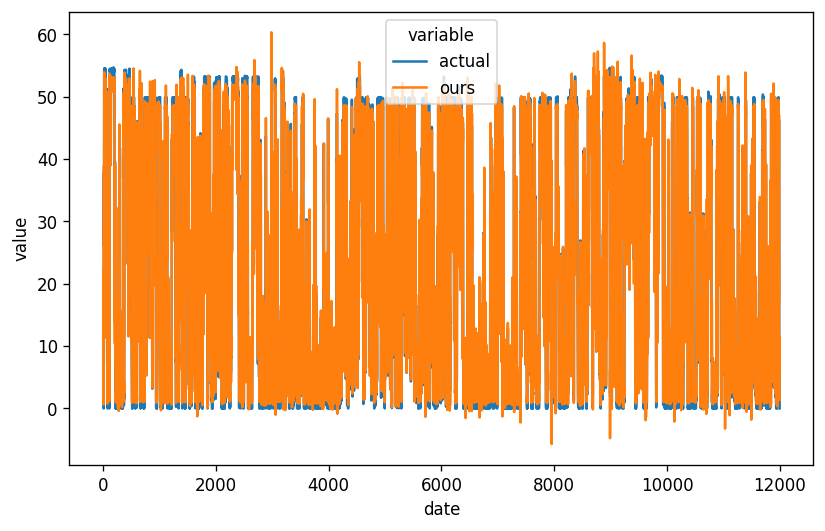

In [154]:
forecast_data = pd.DataFrame({
    "date": y_train.index,
    "actual": y_train,
    "ours": preds,
})

sns.lineplot(x="date", y="value", hue="variable",
             data=pd.melt(forecast_data, ["date"]))

sns.lineplot()